In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import numpy as np
from PIL import Image         
import cv2                 
import matplotlib.pyplot as plt
import csv
import os.path
from os.path import split

Using TensorFlow backend.
C:\Users\myazgan\anaconda3\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# My Data Samples
img_path_prepend = ['/my_data/IMG']
csv_path = './my_data/driving_log.csv'

image_paths = []
angles = []

    # Import driving data from csv
with open(csv_path, newline='') as f:
    driving_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))


    # Gather data - image paths and angles for center, left, right cameras in each row
    for row in driving_data[1:]:
        # skip it if ~0 speed - not representative of driving behavior
        if float(row[6]) < 0.1 :
            continue
        # get center image path and angle
        s = row[0]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3]))
        # get left image path and angle
        s = row[1]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3])+0.225)
        # get left image path and angle
        s = row[2]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3])-0.225)

my_image_paths = np.array(image_paths)
my_angles = np.array(angles)

print('My Data Samples:', my_image_paths.shape, my_angles.shape)

My Data Samples: (26262,) (26262,)


In [3]:
# My Data Samples 2
img_path_prepend = ['/my_data2/IMG']
csv_path = './my_data2/driving_log.csv'

image_paths = []
angles = []

    # Import driving data from csv
with open(csv_path, newline='') as f:
    driving_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))


    # Gather data --> Left,Center,Right camera images and theier correction values
    for row in driving_data[1:]:
        # if ~0 speed - not representative for driving behavior
        if float(row[6]) < 0.1 :
            continue
        # get center image path and angle
        s = row[0]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data2/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3]))
        # get left image path and angle
        s = row[1]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data2/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3])+0.225)
        # get left image path and angle
        s = row[2]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data2/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3])-0.225)

my_image_paths2 = np.array(image_paths)
my_angles2 = np.array(angles)

print('My Data Samples 2:', my_image_paths2.shape, my_angles2.shape)

My Data Samples 2: (34716,) (34716,)


In [4]:
# Track2. In track 2 Steering correction (+,-)0.35 degree. Because Track 2 has more tough curves, I thought that It could be usefull by learning. 
img_path_prepend = ['/my_data/track2/IMG']
csv_path = './my_data/track2/driving_log.csv'

image_paths = []
angles = []

    # Import driving data from csv
with open(csv_path, newline='') as f:
    driving_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))


    # Gather data --> Left,Center,Right camera images and theier correction values
    for row in driving_data[1:]:
        # if ~0 speed - not representative for driving behavior
        if float(row[6]) < 0.1 :
            continue
        # get center image path and angle
        s = row[0]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data/track2/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3]))
        # get left image path and angle
        s = row[1]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data/track2/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3])+0.225)
        # get left image path and angle
        s = row[2]
        s = os.path.split(s)
        filename = s[1].split('\\')[-1]
        name = './my_data/track2/IMG/' + filename
        image_paths.append(name)
        angles.append(float(row[3])-0.225)

track2_image_paths = np.array(image_paths)
track2_angles = np.array(angles)

print('Track2 Data:', track2_image_paths.shape, track2_angles.shape)

Track2 Data: (24075,) (24075,)


In [5]:
# Stack data sources
# This was easy for me to collect data from different sources
image_paths = np.concatenate((my_image_paths2,my_image_paths))
image_paths = np.concatenate((image_paths,track2_image_paths))
print(image_paths.shape)
angles = np.concatenate((my_angles2,my_angles))
angles = np.concatenate((angles,track2_angles))
print(angles.shape)

(85053,)
(85053,)


In [6]:
def preprocess_image(img):
    '''
    It should be same in drive.py
    '''
    # Crop
    pp_img = img[90:135,:,:]
    # Gaussian Blur
    pp_img = cv2.GaussianBlur(pp_img, (3,3), 0)
    # Scaling 
    pp_img = cv2.resize(pp_img,(200, 66), interpolation = cv2.INTER_AREA)
    # convert to YUV color space
    pp_img = cv2.cvtColor(pp_img, cv2.COLOR_BGR2RGB)
    return pp_img

def adjust_brightness(image,angle):
    image_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    brightness = np.random.uniform(low = 0.15, high = 0.95,size=1)
    image_hsv[:,:,2] = image_hsv[:,:,2] * brightness
    new_angle = -1 * angle
    brightness_adjusted = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    return brightness_adjusted,angle

def translation_image(img,angle):
    # this will shift image horizontally and vertically and add a small value--> same in Project2
    rows,cols,ch = img.shape
    range_tr = 100
    dx = range_tr * np.random.uniform() - range_tr/2
    dy = 40 * np.random.uniform()-40/2
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    dst = cv2.warpAffine(img, M, (cols, rows))
    new_angle = angle + dx/range_tr*2*.2
    return dst, new_angle

def flip(img,angle):
    return cv2.flip(img,1),-angle

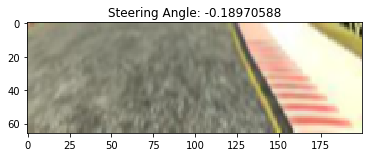

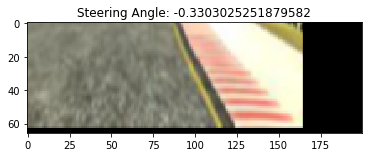

In [7]:
# Example Images
index = 43199
img = cv2.imread(image_paths[index])
#plt.imshow(img) # Original Image
#plt.title('Steering Angle: '+ str(angles[index]))
#plt.savefig('./original_imagetr1.png')
#plt.show()
pp_img = preprocess_image(img)
plt.imshow(pp_img) # Preprocessed Image
plt.title('Steering Angle: '+ str(angles[index]))
plt.savefig('./pp_imagetr2beforshift.png')
plt.show()
tr_img,new_angle = translation_image(pp_img,angles[index])
plt.imshow(tr_img) # Preprocessed Image
plt.title('Steering Angle: '+ str(new_angle))
plt.savefig('./pp_imagetr2aftershift.png')

In [8]:
def generate_training_data(image_paths, angles, batch_size=120, validation_flag=False):
    image_paths, angles = shuffle(image_paths, angles)
    while True:       
        for offset in range(0,len(angles),batch_size):
            batch_samples_paths = image_paths[offset:offset+batch_size]
            batch_samples_angles = angles[offset:offset+batch_size]
            images_gen,angles_gen = ([],[])
            for i in range(len(batch_samples_paths)):
                img = cv2.imread(batch_samples_paths[i])
                angle = batch_samples_angles[i]
                img = preprocess_image(img)
                if not validation_flag:
                    img, angle = translation_image(img, angle)
                    #img, angle = adjust_brightness(img, angle)
                images_gen.append(img)
                angles_gen.append(angle)
            yield (np.array(images_gen), np.array(angles_gen))
            image_paths, angles = shuffle(image_paths, angles)       

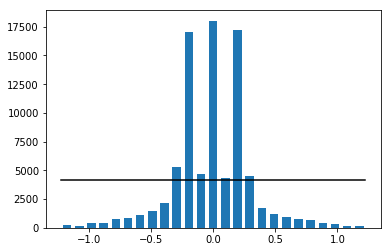

In [9]:
# histogram to see biased steering angle bins, target choosen trial and error.
num_bins = 25
target = 4200
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (target, target), 'k-')
plt.savefig('./beforedist.png')
plt.show()

In [10]:
# don't need so many data between steering angle 0.25 and -0.25 and even in track 2 angle between 0.35 and -0,35 
# thats why I randomly removed data.
import random
out_bin_index = [i for i in range(num_bins) if hist[i] > target]
remove = []
for i in out_bin_index:
    index = np.where((bins[i]< angles) & (angles <= bins[i+1]))
    quantity_remove = len(index[0]) - target
    out = random.sample(list(index[0]),quantity_remove)
    for j in out:
        remove.append(j)
image_paths = np.delete(image_paths, remove, axis=0)
angles = np.delete(angles, remove)

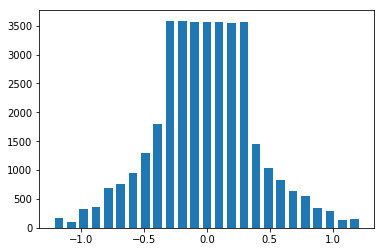

Train: (36888,) (36888,)
Test: (6510,) (6510,)


In [11]:
image_paths_train, image_paths_test, angles_train, angles_test = train_test_split(image_paths, angles,test_size=0.15, random_state=42)
# modified data histogram to produce more even distribution of steering angles
hist, bins = np.histogram(angles_train, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.savefig('./afterdist.png')
plt.show()

print('Train:', image_paths_train.shape, angles_train.shape)
print('Test:', image_paths_test.shape, angles_test.shape)

In [12]:
# Instead of using dropout would prefer batch Normalization and L2 Regularizer to prevent overfitting.
ready = False
if not ready:
    model = Sequential()

    # Normalize
    model.add(Lambda(lambda x: (x/127.5) - 1.0,input_shape=(66,200,3)))
    
    model.add(Conv2D(24, 5, 5,subsample=(2, 2), border_mode='same'))#,W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(36, 5, 5, subsample=(2, 2), border_mode='same'))#,W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(48, 5, 5, subsample=(2, 2), border_mode='same'))#,W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(64, 3, 3, subsample=(1,1),border_mode='same'))#,W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(64, 3, 3, subsample=(1,1),border_mode='same'))#,W_regularizer=l2(0.001)))
    model.add(ELU())
    
    model.add(Flatten())
    model.add(ELU())
    
    model.add(Dense(100))#W_regularizer=l2(0.001)))
    #model.add(Dropout(.5))
    model.add(ELU())

    model.add(Dense(50))#W_regularizer=l2(0.001)))
    #model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(10))#W_regularizer=l2(0.001)))
    #model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
    #model.compile('adam', 'mean_squared_error')
    model.compile(optimizer='adam', loss='mse')

    print(model.summary())
    # initialize generators
    train_gen = generate_training_data(image_paths_train, angles_train, validation_flag=False, batch_size=120)
    val_gen = generate_training_data(image_paths_test, angles_test, validation_flag=True, batch_size=120)

    checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_loss', verbose=2, save_best_only=True)
    #checkpoint = ModelCheckpoint('model{epoch:02d}.h5')
    #earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=2, mode='auto')
    history = model.fit_generator(train_gen, validation_data=val_gen, nb_val_samples=image_paths_test.shape[0], samples_per_epoch=image_paths_train.shape[0],nb_epoch=20, verbose=2, callbacks=[checkpoint])#,earlystop])

   
    

    # Save model data
    #model.save('model.h5')
    print('Model Saved..')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 33, 100, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 33, 100, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 33, 10

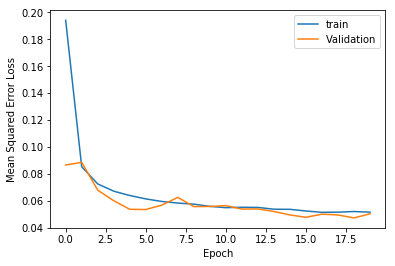

Finished..


In [13]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='upper right')
plt.show()
fig.savefig('test_val_acc.png')
print('Finished..')